1. See whether AI risk is better predicted with tasks
2. Combine tasks, skills and abilities to see if that leads to an even better prediction of AI risk
3. Create occupation clusters based on skills and abilities
4. Create occupation clusters based on tasks
5. See if grouping AI Risk into low, med, high would imporve the model (move from regression to classification)
6. Streamlit app:
- Drop down with occupation, which would provide a prediction of AI Risk
- Recommend similar jobs based on clusters that have a lower AI risk

In [1]:
pip install thefuzz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 32.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

from thefuzz import fuzz
from thefuzz import process
import re
import difflib
import seaborn as sns
import matplotlib.pyplot as plt

import nltk

nltk.download('all')
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,make_scorer,recall_score, accuracy_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor


from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text, DecisionTreeClassifier, plot_tree

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten
import tensorflow as tf
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Bidirectional
from keras import backend as K

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
tf.config.run_functions_eagerly(True)
from sklearn.compose import make_column_transformer
#pip install -U scikit-learn

In [4]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

In [7]:
import joblib

In [418]:
from sklearn.preprocessing import MinMaxScaler

## Import Data

Let's load in the data:
1. Task Ratings - How frequently a task is used by occupation
2. Technology Skills - Technology used by each occupation
3. Task Statements - Tasks performed by occupation
4. AI Risk - AI Risk associated with each occupation

In [8]:
tasks = pd.read_excel("Task Ratings.xlsx")

In [9]:
techskills = pd.read_excel("Technology Skills.xlsx")

In [10]:
taskstatements = pd.read_excel("Task Statements.xlsx")

In [11]:
ai_risk = pd.read_csv("My_Data.csv")

In [238]:
industries = pd.read_csv("All_Industries.csv")

## Review the Data

The data is structured vertically (stacked with tasks assigned a new row by frequency by occupation)

In [ ]:
tasks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161847 entries, 0 to 161846
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   O*NET-SOC Code      161847 non-null  object 
 1   Title               161847 non-null  object 
 2   Task ID             161847 non-null  int64  
 3   Task                161847 non-null  object 
 4   Scale ID            161847 non-null  object 
 5   Scale Name          161847 non-null  object 
 6   Category            125881 non-null  float64
 7   Data Value          161847 non-null  float64
 8   N                   157374 non-null  float64
 9   Standard Error      121275 non-null  float64
 10  Lower CI Bound      109475 non-null  float64
 11  Upper CI Bound      109475 non-null  float64
 12  Recommend Suppress  123453 non-null  object 
 13  Date                161847 non-null  object 
 14  Domain Source       161847 non-null  object 
dtypes: float64(6), int64(1), object(8)

In [ ]:
tasks.head()

,O*NET-SOC Code,Title,Task ID,Task,Scale ID,Scale Name,Category,Data Value,N,Standard Error,Lower CI Bound,Upper CI Bound,Recommend Suppress,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),1.0,5.92,76.0,4.27,1.35,22.44,N,08/2023,Incumbent
1,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),2.0,15.98,76.0,5.60,7.65,30.40,N,08/2023,Incumbent
2,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),3.0,29.68,76.0,9.53,14.52,51.18,N,08/2023,Incumbent
3,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),4.0,21.18,76.0,8.39,8.99,42.23,N,08/2023,Incumbent
4,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,FT,Frequency of Task (Categories 1-7),5.0,19.71,76.0,7.37,8.85,38.29,N,08/2023,Incumbent


In [ ]:
taskstatements.head()

,O*NET-SOC Code,Title,Task ID,Task,Task Type,Incumbents Responding,Date,Domain Source
0,11-1011.00,Chief Executives,8823,Direct or coordinate an organization's financi...,Core,95.0,08/2023,Incumbent
1,11-1011.00,Chief Executives,8824,"Confer with board members, organization offici...",Core,95.0,08/2023,Incumbent
2,11-1011.00,Chief Executives,8827,"Prepare budgets for approval, including those ...",Core,95.0,08/2023,Incumbent
3,11-1011.00,Chief Executives,8826,"Direct, plan, or implement policies, objective...",Core,94.0,08/2023,Incumbent
4,11-1011.00,Chief Executives,8834,Prepare or present reports concerning activiti...,Core,95.0,08/2023,Incumbent


In [ ]:
techskills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32384 entries, 0 to 32383
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   O*NET-SOC Code   32384 non-null  object
 1   Title            32384 non-null  object
 2   Example          32384 non-null  object
 3   Commodity Code   32384 non-null  int64 
 4   Commodity Title  32384 non-null  object
 5   Hot Technology   32384 non-null  object
 6   In Demand        32384 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


In [ ]:
#ai_risk.info()

In [15]:
ai_risk.rename(columns = {
    "Job titiles" : "Job_title"
}, inplace = True)

In [73]:
ai_risk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4706 entries, 0 to 4705
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Job titiles        4706 non-null   object 
 1   AI Impact          4706 non-null   object 
 2   Tasks              4706 non-null   int64  
 3   AI models          4706 non-null   int64  
 4   AI_Workload_Ratio  4706 non-null   float64
 5   Domain             4706 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 220.7+ KB


In [16]:
ai_risk["AI Impact"] = ai_risk["AI Impact"].str.rstrip('%').astype(float)

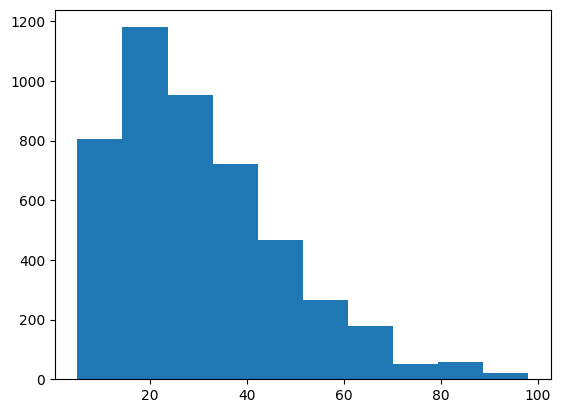

In [102]:
plt.hist(ai_risk["AI Impact"], bins=10);

In [101]:
ai_risk.sort_values(by="AI Impact", ascending=False).head(200)

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain,rank,rank_new
0,Communications Manager,98.0,365,2546,0.143362,Communication & PR,high,3
2,Data Entry,95.0,325,2278,0.142669,Administrative & Clerical,high,3
3,Mail Clerk,95.0,193,1366,0.141288,Leadership & Strategy,high,3
1,Data Collector,95.0,299,2148,0.139199,Data & IT,high,3
4,Compliance Officer,92.0,194,1369,0.141709,Medical & Healthcare,high,3
...,...,...,...,...,...,...,...,...
161,Medical Billing Specialist,70.0,124,827,0.149940,Data & IT,med,2
170,Front End Engineer,70.0,158,1093,0.144556,Communication & PR,med,2
169,Front End Developer,70.0,159,1104,0.144022,Hospitality,med,2
168,Entry Level Developer,70.0,151,1033,0.146176,Sales & Marketing,med,2


In [17]:
conditions = [
    (ai_risk["AI Impact"].astype(float) >= 75),
    (ai_risk["AI Impact"].astype(float) <= 25),
]

choices = ["high", "low"]

In [18]:
ai_risk["rank"] = np.select(conditions, choices, "med")


In [19]:
ai_risk["rank"] = ai_risk["rank"].astype('category')

In [20]:
ai_risk["rank_new"] = ai_risk["rank"].cat.codes

In [207]:
dict_map = {0: 3, 1:1, 2:2}
ai_risk["rank_new"] = ai_risk["rank_new"].map(dict_map)

In [208]:
ai_risk["rank_new"].value_counts(normalize=True)

1    0.511687
2    0.460688
3    0.027624
Name: rank_new, dtype: float64

In [99]:
ai_risk[ai_risk["AI Impact"] >= 50]

,Job titiles,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain,rank,rank_new
0,Communications Manager,98.0,365,2546,0.143362,Communication & PR,high,3
1,Data Collector,95.0,299,2148,0.139199,Data & IT,high,3
2,Data Entry,95.0,325,2278,0.142669,Administrative & Clerical,high,3
3,Mail Clerk,95.0,193,1366,0.141288,Leadership & Strategy,high,3
4,Compliance Officer,92.0,194,1369,0.141709,Medical & Healthcare,high,3
...,...,...,...,...,...,...,...,...
799,Early Intervention Specialist,50.0,418,1440,0.290278,Hospitality,med,2
800,Interior Decorator,50.0,408,1792,0.227679,Communication & PR,med,2
801,Criminal Analyst,50.0,470,1602,0.293383,Data & IT,med,2
802,Evidence Technician,50.0,380,1370,0.277372,Administrative & Clerical,med,2


### Reconfigure the dataset to be a crosstab

Select all task rows, regardless of frequency of use.

In [13]:
tasks_importance = tasks[tasks["Scale Name"] == "Importance"]

Count how many entries (abilities and skills) there are per title in the dataset

In [ ]:
## Number of Tasks
tasks_importance.shape[0]

17983

Drop columns not used in the analysis.

In [14]:
## Shorten the datasets for easier use
def drop_columns(x):
  x.drop(columns=['Title',
                  'Scale ID',
                  'Scale Name',
                  'Category',
                  'N',
                  'Standard Error',
                  'Lower CI Bound',
                  'Upper CI Bound',
                  'Recommend Suppress',
                  'Date',
                  'Domain Source'], inplace = True)


In [15]:
sources = [tasks_importance]
for source in sources:
  drop_columns(source)

<ipython-input-14-6c7c2b39a7cd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(columns=['Title',


Create an SOC-Title Index for future use

In [16]:
tasks_importance_task_crosstab = tasks_importance.groupby("O*NET-SOC Code")["Task"].apply(','.join).reset_index()

Combine by Task and Occupation



In [17]:
tasks_importance_crosstab = pd.crosstab(tasks_importance["O*NET-SOC Code"], tasks_importance["Task ID"],
                                            values=tasks_importance["Data Value"], aggfunc='mean').round(1)

In [18]:
tasks_importance_crosstab.reset_index(inplace=True)

In [ ]:
#tasks_grouped = tasks.drop_duplicates(["O*NET-SOC Code", "Title"])

In [ ]:
#full_dataset = tasks_grouped.fillna(0)

##Clean up job titles in Occupations Dataset

In [16]:
title_ref = tasks[tasks["Scale Name"] == "Importance"].groupby("O*NET-SOC Code")["Title"].apply(np.unique)

In [17]:
title_ref_ = pd.DataFrame(title_ref)

In [18]:
title_ref_.reset_index()

,O*NET-SOC Code,Title
0,11-1011.00,[Chief Executives]
1,11-1011.03,[Chief Sustainability Officers]
2,11-1021.00,[General and Operations Managers]
3,11-2011.00,[Advertising and Promotions Managers]
4,11-2021.00,[Marketing Managers]
...,...,...
868,53-7071.00,[Gas Compressor and Gas Pumping Station Operat...
869,53-7072.00,"[Pump Operators, Except Wellhead Pumpers]"
870,53-7073.00,[Wellhead Pumpers]
871,53-7081.00,[Refuse and Recyclable Material Collectors]


In [18]:
title_ref_["Adj_title"] = title_ref_['Title'].agg(lambda x: ','.join(map(str, x)))

In [19]:
full_dataset_title = title_ref_["Adj_title"]

In [20]:
full_dataset_title_ = [re.split(r',|, and', x) for x in full_dataset_title]

In [21]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-1] == "s":
      x[y] = x[y].rstrip(x[y][-1])

In [22]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][-2:] == "ie":
      x[y] = re.sub(r'.{2}$',"y",x[y])

In [23]:
for x in full_dataset_title_:
  for y in range(len(x)):
      x[y] = x[y].replace('s and',"")

In [24]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0:5] == " and ":
      x[y] = re.sub(r'^.{0,5}', "", x[y])

In [25]:
for x in full_dataset_title_:
  for y in range(len(x)):
    if x[y][0] == " ":
      x[y] = x[y].strip()

In [26]:
exceptions = []
for x in full_dataset_title_:
  for y in range(len(x)):
    if "except" in x[y]:
      m = y
      for y in range(m,len(x)+1):
        exceptions.append(x[y])

Split on "," and "and":

Split occupation titles on ", and " and ", "
Replace "ie" at the end of occupations with "y"
Strip "s" at the end of occupations (problems with certain fields like "gas" and "waitresses")
Trim leading spaces
Remove all words following "except"

In [27]:
full_dataset_title_split = pd.DataFrame(full_dataset_title_, columns=['Title1','Title2','Title3',
                                            'Title4','Title5','Title6','Title7'])

In [28]:
title_ref_.reset_index()

,O*NET-SOC Code,Title,Adj_title
0,11-1011.00,[Chief Executives],Chief Executives
1,11-1011.03,[Chief Sustainability Officers],Chief Sustainability Officers
2,11-1021.00,[General and Operations Managers],General and Operations Managers
3,11-2011.00,[Advertising and Promotions Managers],Advertising and Promotions Managers
4,11-2021.00,[Marketing Managers],Marketing Managers
...,...,...,...
868,53-7071.00,[Gas Compressor and Gas Pumping Station Operat...,Gas Compressor and Gas Pumping Station Operators
869,53-7072.00,"[Pump Operators, Except Wellhead Pumpers]","Pump Operators, Except Wellhead Pumpers"
870,53-7073.00,[Wellhead Pumpers],Wellhead Pumpers
871,53-7081.00,[Refuse and Recyclable Material Collectors],Refuse and Recyclable Material Collectors


In [29]:
full_dataset_combined = full_dataset_title_split.merge(title_ref_.reset_index()[["Adj_title", "O*NET-SOC Code"]],
                                                          left_index = True, right_index = True, how="inner")

In [32]:
full_dataset_combined.isna().sum()

Title1              0
Title2            639
Title3            760
Title4            824
Title5            860
Title6            868
Title7            871
Adj_title           0
O*NET-SOC Code      0
dtype: int64

##Analyzing our dataset
Matching titles across datasets

Trying Fuzzy Match

In [30]:
full_dataset_combined["Match_Column"] = full_dataset_combined["Adj_title"]

In [31]:
full_dataset_combined.rename(columns={"Adj_title":"Title"},inplace=True)

In [32]:
full_dataset_combined.columns

Index(['Title1', 'Title2', 'Title3', 'Title4', 'Title5', 'Title6', 'Title7',
       'Title', 'O*NET-SOC Code', 'Match_Column'],
      dtype='object')

In [ ]:
#full_dataset_occupations_copy_titles.drop(columns = ["Unnamed: 0"], inplace=True)

In [33]:
ai_risk.columns

Index(['Job titiles', 'AI Impact', 'Tasks', 'AI models', 'AI_Workload_Ratio',
       'Domain'],
      dtype='object')

In [35]:
full_dataset_combined["Match_Column"]= full_dataset_combined["Title"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"]))


In [36]:
full_dataset_combined["Match_Column_unpacked"] = full_dataset_combined["Match_Column"].apply("|".join)

In [37]:
full_dataset_combined["Match_Ratio"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [38]:
full_dataset_combined["Match_Ratio_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_unpacked, x.Title), axis=1)

In [39]:
full_dataset_combined["Match_Column_1"]= full_dataset_combined["Title1"].apply(lambda x: difflib.get_close_matches(x, ai_risk["Job_title"])[0] if len(difflib.get_close_matches(x, ai_risk["Job_title"])) != 0 else difflib.get_close_matches(x, ai_risk["Job_title"]))


In [40]:
full_dataset_combined["Match_Ratio_1"] = full_dataset_combined.apply(lambda x: fuzz.ratio(x.Match_Column_1, x.Title1), axis=1)

In [41]:
full_dataset_combined["Match_Ratio_1_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title1), axis=1)

In [42]:
full_dataset_combined["Match_Ratio_1b_tokens"]= full_dataset_combined.apply(lambda x: fuzz.token_sort_ratio(x.Match_Column_1, x.Title), axis=1)

In [44]:
full_dataset_combined["Match_Ratio_1_tokens"].value_counts(ascending= False).head()

100    303
0      116
67      31
70      21
76      17
Name: Match_Ratio_1_tokens, dtype: int64

In [51]:
full_dataset_combined[full_dataset_combined["Title2"].notna()].head(100)

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens
18,Transportation,Storage,Distribution Manager,None,None,None,None,"Transportation, Storage, and Distribution Mana...",11-3071.00,[Transportation Manager],Transportation Manager,61,63,Transportation Driver,80,80,58
23,Farmer,Rancher,Other Agricultural Manager,None,None,None,None,"Farmers, Ranchers, and Other Agricultural Mana...",11-9013.00,[],,0,0,Farmer,100,100,22
25,Education and Childcare Administrator,Preschool and Daycare,None,None,None,None,None,"Education and Childcare Administrators, Presch...",11-9031.00,[],,0,0,Education Administrator,77,77,55
26,Education Administrator,Kindergarten through Secondary,None,None,None,None,None,"Education Administrators, Kindergarten through...",11-9032.00,[],,0,0,Education Administrator,100,100,59
27,Education Administrator,Postsecondary,None,None,None,None,None,"Education Administrators, Postsecondary",11-9033.00,"[Education Administrator, Construction Adminis...",Education Administrator|Construction Administr...,72,61,Education Administrator,100,100,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,Cook,Restaurant,None,None,None,None,None,"Cooks, Restaurant",35-2014.00,"[Restaurant, Restaurant Host]",Restaurant|Restaurant Host,51,62,Cook,100,100,40
477,Cook,Short Order,None,None,None,None,None,"Cooks, Short Order",35-2015.00,[Short Order Cook],Short Order Cook,65,97,Cook,100,100,38
483,Food Server,Nonrestaurant,None,None,None,None,None,"Food Servers, Nonrestaurant",35-3041.00,[Food Service Director],Food Service Director,62,47,Food Server,100,100,59
486,Host Hostesse,Restaurant,Lounge,Coffee Shop,None,None,None,"Hosts and Hostesses, Restaurant, Lounge, and C...",35-9031.00,[],,0,0,Hostess,70,70,23


In [55]:
print(f"Full Title Match Ratio: {round(np.mean(full_dataset_combined.Match_Ratio),2)}")
print(f"Full Title Match Ratio (Unordered): {round(np.mean(full_dataset_combined.Match_Ratio_tokens),2)}")
print(f"Partial Title Match Ratio: {round(np.mean(full_dataset_combined.Match_Ratio_1),2)}")
print(f"Partial Title Match Ratio (Unordered): {round(np.mean(full_dataset_combined.Match_Ratio_1_tokens),2)}")
print(f"Partial Title Match Ratio (Unordered, matched to full title): {round(np.mean(full_dataset_combined.Match_Ratio_1b_tokens),2)}")

Full Title Match Ratio: 34.42
Full Title Match Ratio (Unordered): 34.73
Partial Title Match Ratio: 73.07
Partial Title Match Ratio (Unordered): 71.29
Partial Title Match Ratio (Unordered, matched to full title): 61.11


In [57]:
print(f"Full Title Match Ratio: {round((full_dataset_combined[full_dataset_combined.Match_Ratio >=50]).count(),2)}")
print(f"Full Title Match Ratio (Unordered): {round((full_dataset_combined[full_dataset_combined.Match_Ratio_tokens >=50]).count(),2)}")
print(f"Partial Title Match Ratio: {round((full_dataset_combined[full_dataset_combined.Match_Ratio_1 >=50]).count(),2)}")
print(f"Partial Title Match Ratio (Unordered): {round((full_dataset_combined[full_dataset_combined.Match_Ratio_1_tokens >=50]).count(),2)}")
print(f"Partial Title Match Ratio (Unordered, matched to full title): {round((full_dataset_combined[full_dataset_combined.Match_Ratio_1b_tokens >=50]).count(),2)}")

Full Title Match Ratio: Title1                   331
Title2                    47
Title3                     4
Title4                     0
Title5                     0
Title6                     0
Title7                     0
Title                    331
O*NET-SOC Code           331
Match_Column             331
Match_Column_unpacked    331
Match_Ratio              331
Match_Ratio_tokens       331
Match_Column_1           331
Match_Ratio_1            331
Match_Ratio_1_tokens     331
Match_Ratio_1b_tokens    331
dtype: int64
Full Title Match Ratio (Unordered): Title1                   339
Title2                    41
Title3                     4
Title4                     0
Title5                     0
Title6                     0
Title7                     0
Title                    339
O*NET-SOC Code           339
Match_Column             339
Match_Column_unpacked    339
Match_Ratio              339
Match_Ratio_tokens       339
Match_Column_1           339
Match_Ratio_1            339

Partial Title Match Ratio has the highest average match, and the highest count of Titles with a match ratio >= 50%.


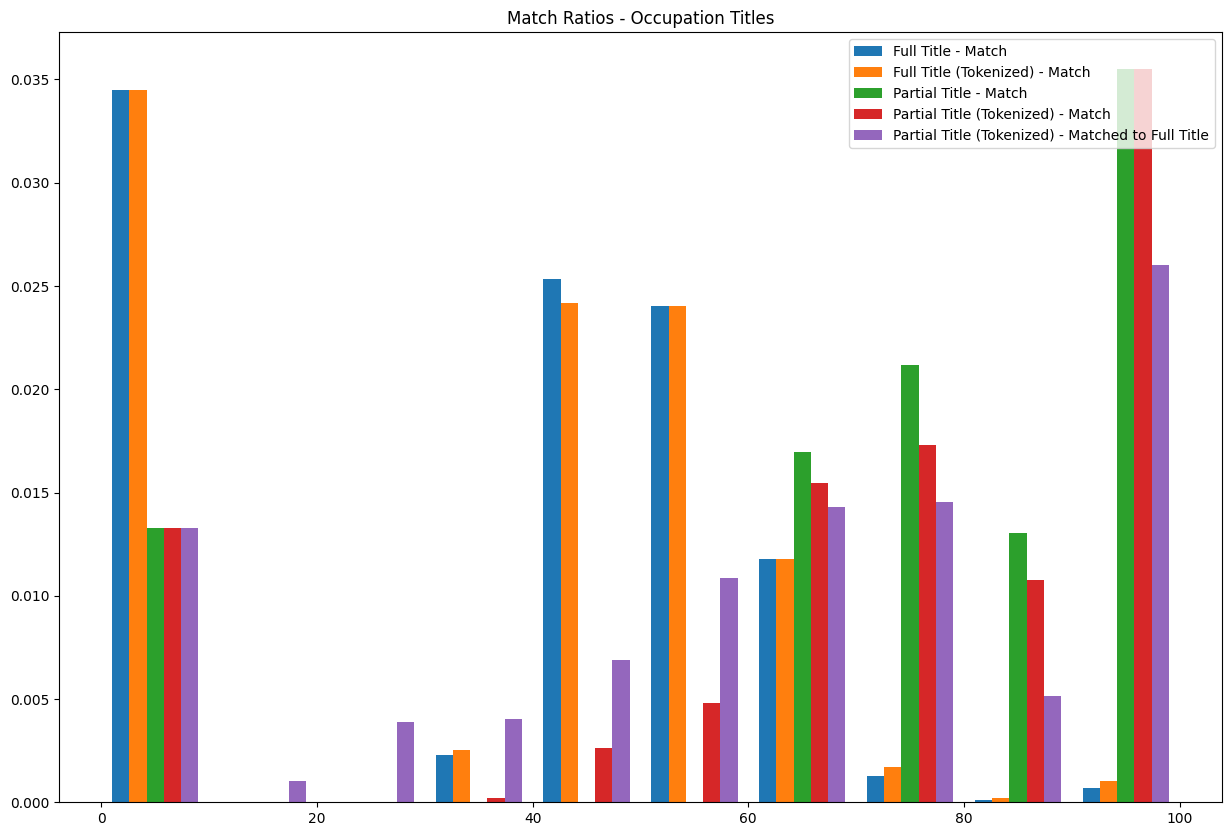

In [58]:
x = full_dataset_combined[["Match_Ratio", "Match_Ratio_tokens", "Match_Ratio_1","Match_Ratio_1_tokens","Match_Ratio_1b_tokens"]]
plt.figure(figsize=(15,10))
plt.hist(x, density=True, histtype='bar')
plt.title('Match Ratios - Occupation Titles')
plt.legend(["Full Title - Match", "Full Title (Tokenized) - Match","Partial Title - Match", "Partial Title (Tokenized) - Match", "Partial Title (Tokenized) - Matched to Full Title"], loc ="upper right", fontsize = '10');

Let's see if we can get more matches in the titles that have low Match Scores using our preferred matching method.

In [89]:
full_dataset_combined_poor_matches = full_dataset_combined[full_dataset_combined["Match_Ratio_1"]<50]
full_dataset_combined_poor_matches.head(50)

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens
81,Appraiser Assessors of Real Estate,None,None,None,None,None,None,Appraisers and Assessors of Real Estate,13-2023.00,[],,0,0,[],0,0,0
239,Child,Family,School Social Worker,None,None,None,None,"Child, Family, and School Social Workers",21-1021.00,"[School Social Worker, Clinical Social Worker]",School Social Worker|Clinical Social Worker,55,62,[],0,0,0
263,Atmospheric,Earth,Marine,Space Sciences Teacher,Postsecondary,None,None,"Atmospheric, Earth, Marine, and Space Sciences...",25-1051.00,[],,0,0,[],0,0,0
268,Area,Ethnic,Cultural Studies Teacher,Postsecondary,None,None,None,"Area, Ethnic, and Cultural Studies Teachers, P...",25-1062.00,[],,0,0,[],0,0,0
278,Criminal Justice and Law Enforcement Teacher,Postsecondary,None,None,None,None,None,"Criminal Justice and Law Enforcement Teachers,...",25-1111.00,[],,0,0,[],0,0,0
301,Adult Basic Education,Adult Secondary Education,English as a Second Language Instructor,None,None,None,None,"Adult Basic Education, Adult Secondary Educati...",25-3011.00,[],,0,0,[],0,0,0
309,Farm and Home Management Educator,None,None,None,None,None,None,Farm and Home Management Educators,25-9021.00,[],,0,0,[],0,0,0
321,Merchandise Displayer Window Trimmer,None,None,None,None,None,None,Merchandise Displayers and Window Trimmers,27-1026.00,[],,0,0,[],0,0,0
329,Coache Scout,None,None,None,None,None,None,Coaches and Scouts,27-2022.00,[],,0,0,[],0,0,0
335,Broadcast Announcer Radio Disc Jockey,None,None,None,None,None,None,Broadcast Announcers and Radio Disc Jockeys,27-3011.00,[],,0,0,[],0,0,0


In [88]:
full_dataset_combined_poor_matches.loc[full_dataset_combined_poor_matches["Title1"] == "Wellhead Pumper"]


,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens,Manual_Title
870,Wellhead Pumper,None,None,None,None,None,None,Wellhead Pumpers,53-7073.00,[Wellness Nurse],Wellness Nurse,60.0,60.0,[],0.0,0.0,0.0,Wellhead Pumper


In [214]:
replacements = {"Appraiser Assessors": "Appraiser",
                "Refuse": "Trash",
                "Wellhead":"Pumper",
                "Gas Pumping Station Operator": "Gas Station Attendant",
                "Cleaners of Vehicle Equipment": "Cabin Cleaner",
                "Pipelayer":"Pipefitter",
                "Iron and Rebar":"Iron",
                "Stucco Mason" : "Mason",
                "Drywall and Ceiling Tile": "Tile",
                "Chef Head":"Chef",
                "Transit and Railroad Police": "Special Police Officer",
                "Police and Sheriff's Patrol": "Police Officer",
                "Claim Policy Processing": "Insurance",
                "Other Construction Equipment": "Other",
                "Stone Setter" : "Stone Mason",
                "Blockmason": "Stone Mason",
                "Reservation and Transportation": "Travel",
                "Gambling Change Person Booth": "Casino",
                "Door-to-Door": "Street",
                "Demonstrator": "Promoter",
                "Groundskeeping": "Landscaping",
                "Gambling Services": "Casino",
                "Fast Food and Counter": "Food Service",
                "Bellhop": "Porter",
                "Motion Picture": "Film",
                "Captioner": "Interpreter",
                "Coache": "Coach",
                "Radio Disc Jockey": "Announcer",


}
replacements_ = {r"\b{}\b".format(k): v for k, v in replacements.items()}

In [90]:
pd.options.mode.chained_assignment = None

In [215]:
full_dataset_combined_poor_matches["Manual_Title"] = full_dataset_combined_poor_matches["Title1"].replace(replacements_, regex=True)

In [140]:
full_dataset_combined_poor_matches["Manual_Title"]

81                         Appraiser of Real Estate
239                                           Child
263                                     Atmospheric
268                                            Area
278    Criminal Justice and Law Enforcement Teacher
                           ...                     
862                                   Cabin Cleaner
864                Recycling and Reclamation Worker
868        Gas Compressor and Gas Station Attendant
870                                          Pumper
871         Trash and Recyclable Material Collector
Name: Manual_Title, Length: 116, dtype: object

In [212]:
job_threat_lookup = ai_risk[ai_risk["Job_title"].str.contains("Promoter")]
job_threat_lookup

,Job_title,AI Impact,Tasks,AI models,AI_Workload_Ratio,Domain
4184,Promoter,10%,998,4516,0.220992,Medical & Healthcare


In [216]:
full_dataset_combined_poor_matches["Match_Column_1_adj"]= full_dataset_combined_poor_matches["Manual_Title"].apply(lambda x: difflib.get_close_matches(x,
                                                                                                                   ai_risk["Job_title"])[0] if len(difflib.get_close_matches(x,
                                                                                                                   ai_risk["Job_title"])) != 0 else difflib.get_close_matches(x, ai_risk["Job_title"]))

In [217]:
full_dataset_combined_poor_matches["Match_Ratio_1_adj"] = full_dataset_combined_poor_matches.apply(lambda x: fuzz.ratio(x.Match_Column_1_adj, x.Manual_Title), axis=1)

In [182]:
full_dataset_combined_poor_matches

,Title1,Title2,Title3,Title4,Title5,Title6,Title7,Title,O*NET-SOC Code,Match_Column,Match_Column_unpacked,Match_Ratio,Match_Ratio_tokens,Match_Column_1,Match_Ratio_1,Match_Ratio_1_tokens,Match_Ratio_1b_tokens,Manual_Title,Match_Column_1_adj,Match_Ratio_1_adj
81,Appraiser Assessors of Real Estate,None,None,None,None,None,None,Appraisers and Assessors of Real Estate,13-2023.00,[],,0,0,[],0,0,0,Appraiser of Real Estate,[],0
239,Child,Family,School Social Worker,None,None,None,None,"Child, Family, and School Social Workers",21-1021.00,"[School Social Worker, Clinical Social Worker]",School Social Worker|Clinical Social Worker,55,62,[],0,0,0,Child,[],0
263,Atmospheric,Earth,Marine,Space Sciences Teacher,Postsecondary,None,None,"Atmospheric, Earth, Marine, and Space Sciences...",25-1051.00,[],,0,0,[],0,0,0,Atmospheric,[],0
268,Area,Ethnic,Cultural Studies Teacher,Postsecondary,None,None,None,"Area, Ethnic, and Cultural Studies Teachers, P...",25-1062.00,[],,0,0,[],0,0,0,Area,[],0
278,Criminal Justice and Law Enforcement Teacher,Postsecondary,None,None,None,None,None,"Criminal Justice and Law Enforcement Teachers,...",25-1111.00,[],,0,0,[],0,0,0,Criminal Justice and Law Enforcement Teacher,[],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
862,Cleaners of Vehicle Equipment,None,None,None,None,None,None,Cleaners of Vehicles and Equipment,53-7061.00,[],,0,0,Cabin Cleaner,0,0,0,Cabin Cleaner,Cabin Cleaner,100
864,Recycling and Reclamation Worker,None,None,None,None,None,None,Recycling and Reclamation Workers,53-7062.04,[],,0,0,[],0,0,0,Recycling and Reclamation Worker,[],0
868,Gas Compressor and Gas Pumping Station Operator,None,None,None,None,None,None,Gas Compressor and Gas Pumping Station Operators,53-7071.00,[],,0,0,Gas Station Attendant,0,0,0,Gas Compressor and Gas Station Attendant,Gas Station Attendant,69
870,Wellhead Pumper,None,None,None,None,None,None,Wellhead Pumpers,53-7073.00,[Wellness Nurse],Wellness Nurse,60,60,Pumper,0,0,0,Pumper,Pumper,92


In [218]:
full_dataset_combined_poor_matches[full_dataset_combined_poor_matches.Match_Ratio_1_adj != 0].count( )/full_dataset_combined_poor_matches.count()

Title1                   0.172414
Title2                   0.060606
Title3                   0.076923
Title4                   0.076923
Title5                   0.000000
Title6                   0.000000
Title7                   0.000000
Title                    0.172414
O*NET-SOC Code           0.172414
Match_Column             0.172414
Match_Column_unpacked    0.172414
Match_Ratio              0.172414
Match_Ratio_tokens       0.172414
Match_Column_1           0.172414
Match_Ratio_1            0.172414
Match_Ratio_1_tokens     0.172414
Match_Ratio_1b_tokens    0.172414
Manual_Title             0.172414
Match_Column_1_adj       0.172414
Match_Ratio_1_adj        0.172414
dtype: float64

## Feeding in the Target Values

In [43]:
def partial_match(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'AI Impact'].iloc[0]

In [44]:
def partial_match_(x):
    return ai_risk.loc[(ai_risk['Job_title'] == x), 'Job_title'].iloc[0]

In [45]:
full_dataset_combined["Match_Column_1"] = full_dataset_combined["Match_Column_1"].apply(lambda y: "" if y==[] else y)

In [46]:
full_dataset_combined_ = pd.merge(left=full_dataset_combined, right=ai_risk,
                                  left_on="Match_Column_1", right_on = "Job_title", how="left")

In [47]:
full_dataset_combined_.dropna(subset = ["AI Impact"], inplace=True)

In [48]:
full_dataset_combined_.rename(columns = {
    "AI Impact" : "aiimpact"
}, inplace = True)

In [13]:
full_dataset_combined_.to_pickle("./title_match.pkl")

NameError: ignored

Experimenting with including Job Titles

In [513]:
full_dataset_combined_ = pd.read_pickle(r'./title_match.pkl')

In [20]:
full_dataset_combined_analysis = pd.merge(left=full_dataset_combined_, right=tasks_importance_task_crosstab,
                                          left_on=["O*NET-SOC Code"], right_on=["O*NET-SOC Code"], how = "left" )

In [21]:
stops = nltk.corpus.stopwords.words('english')
new_stop_words = ["whom"]
stops.extend(new_stop_words)

In [22]:
def text_process(text):
  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()

  words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
  sentence = " ".join(words)
  splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
  list_of_sentences = " ".join(splits)

  return list_of_sentences

In [23]:
df_lemm_task = full_dataset_combined_analysis["Task"].apply(text_process)
df_lemm_title = full_dataset_combined_analysis["Title"].apply(text_process)

Because the tasks are mutually exclusive by Occupation, it's difficult to use them as a predictor.

What about, if we use the words in the tasks to indicate AI risk?

In [521]:
tasks_for_model = pd.DataFrame(df_lemm_task)

In [522]:
titles_for_model = pd.DataFrame(df_lemm_title)

Let's visualize the most frequent 3-word combinations in Task and Title text, categorized by AI Risk.

In [523]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_task)
cvec_transform = cvec.transform(df_lemm_task)
tasks_lemmed = pd.DataFrame(cvec_transform.todense(), columns=cvec.get_feature_names_out())

In [524]:
cvec = CountVectorizer(ngram_range=(3, 3), stop_words=stops)
cvec.fit(df_lemm_title)
cvec_transformed = cvec.transform(df_lemm_title)
titles_lemmed = pd.DataFrame(cvec_transformed.todense(), columns=cvec.get_feature_names_out())

In [525]:
ytask = full_dataset_combined_analysis["rank_new"]

In [526]:
y_lemm = pd.DataFrame(ytask)
y_lemm = y_lemm.reset_index(drop=True)

In [527]:
tasks_lemmed_ = pd.merge(tasks_lemmed, y_lemm, left_index=True, right_index=True)


In [528]:
titles_lemmed_ = pd.merge(titles_lemmed, y_lemm, left_index=True, right_index=True)

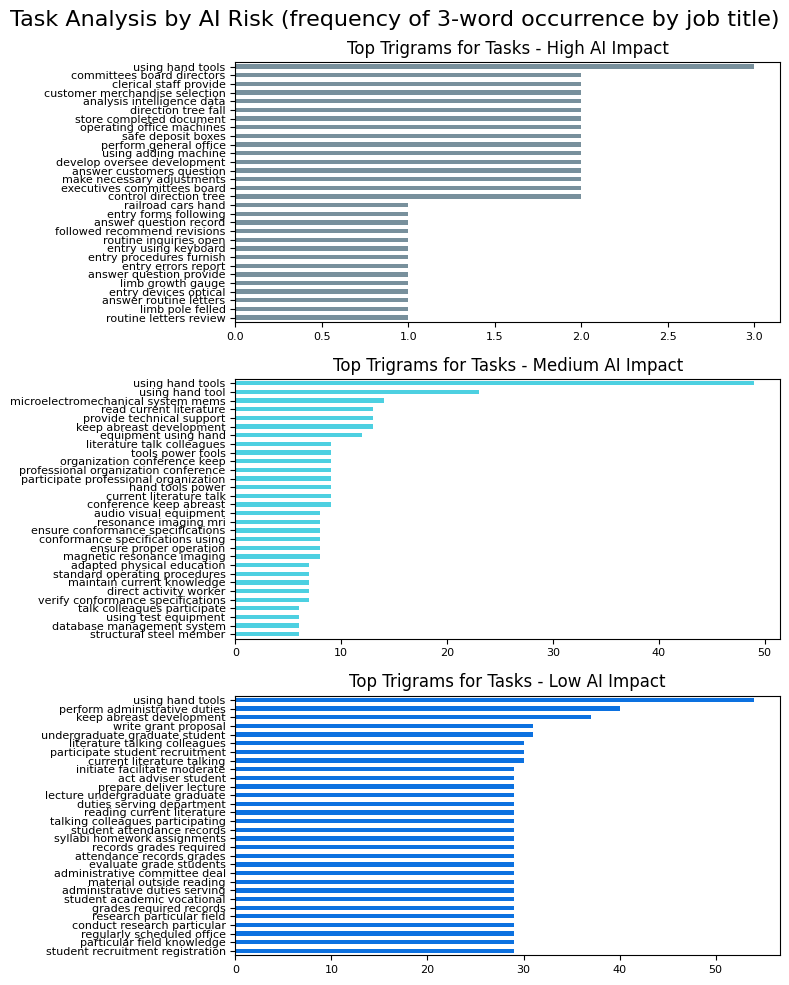

In [529]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), tight_layout=True)

(tasks_lemmed_[tasks_lemmed_['rank_new'] == 0]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tasks - High AI Impact', color='#78909c', fontsize=8, ax=axes[0])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 2]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tasks - Medium AI Impact', color='#4dd0e1', fontsize=8, ax=axes[1])).invert_yaxis();


(tasks_lemmed_[tasks_lemmed_['rank_new'] == 1]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tasks - Low AI Impact', color='#0c71e0', fontsize=8, ax=axes[2])).invert_yaxis();


fig.suptitle('Task Analysis by AI Risk (frequency of 3-word occurrence by job title)', fontsize=16)
plt.savefig('Task Frequency by AI Risk.jpg');

Insert histogram of counts (jobs per task); consider color coding by AI risk

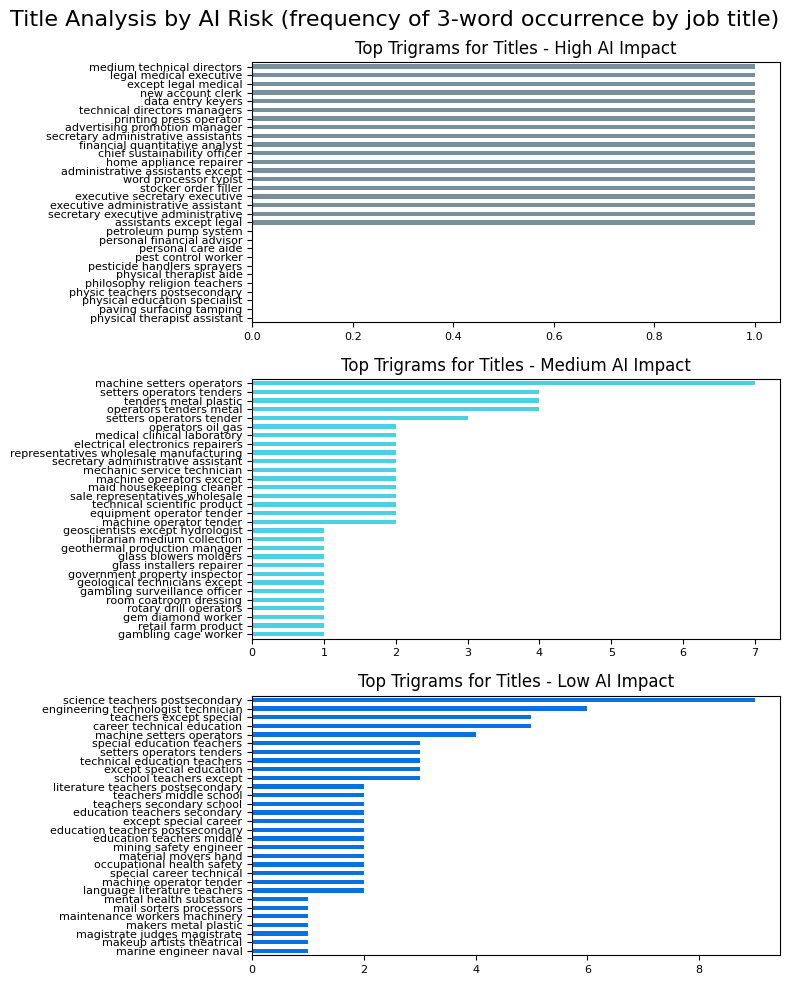

In [530]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), tight_layout=True)

(titles_lemmed_[titles_lemmed_['rank_new'] == 0]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Titles - High AI Impact', color='#78909c', fontsize=8, ax=axes[0])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 2]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Titles - Medium AI Impact', color='#4dd0e1', fontsize=8, ax=axes[1])).invert_yaxis();


(titles_lemmed_[titles_lemmed_['rank_new'] == 1]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Titles - Low AI Impact', color='#0c71e0', fontsize=8, ax=axes[2])).invert_yaxis();


fig.suptitle('Title Analysis by AI Risk (frequency of 3-word occurrence by job title)', fontsize=16)
plt.savefig('Title Frequency by AI Risk.jpg');

## Analysis

In [532]:
def evaluation(name_of_the_model, y_test, preds, gs_model, X_train, X_test):
    ## find the confusion matrix
    cm = confusion_matrix(y_test, preds)
    tp = cm[1][1]; #True positives
    tn = cm[0][0]; #True negatives
    fp = cm[0][1]; #False positives
    fn = cm[1][0]; #False negatives

    #Calculate Sensitivity, Specificity, Precision, and F1_Score

    Sensitivity = round(tp/(tp + fn),3)
    Specificity = round(tn/(tn + fp),3)
    Precision = round(tp/(tp + fp),3)
    F1_Score = round(2 * (Precision * Sensitivity) / (Precision + Sensitivity),3)

    #Model scores for train and test

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test, y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' : name_of_the_model,
        'Score on train': train_score ,
        'Score on test': test_score,
         'Sensitivity': Sensitivity,
         'Specificity': Specificity,
         'Precision' : Precision,
         'F1 Score' : F1_Score
        },index=[0]
    )

    return df #Display the dataframe

### Tasks Analysis

Let's run a model for task NLP

In [531]:
Xtask_train, Xtask_test, y_train, y_test = train_test_split(df_lemm_task,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

### Logistic Regression

1.   Count Vector - Task
2.  Count Vector - Title



In [106]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2],
    'cvec__max_df' : [0.9, 0.95],
    'cvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'cvec__stop_words' : [stops]
}

In [107]:
pipe_cvec_logr_task = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver='liblinear'))
])

In [108]:
gs_task_cvec_logr = GridSearchCV(pipe_cvec_logr_task,
                pipe_params_cvec,
                  cv = 5)

In [111]:
gs_task_cvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [112]:
gs_task_cvec_logr_preds = gs_task_cvec_logr.predict(Xtask_test)

In [113]:
logistic_cvec = evaluation("Logistical Regression CVEC", y_test, gs_task_cvec_logr_preds, gs_task_cvec_logr, Xtask_train, Xtask_test)

In [114]:
logistic_cvec

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC,0.91,0.579,1.0,0.0,0.973,0.986


In [171]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : [stops],
}

In [172]:
pipe_tvec_logr_task = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [173]:
gs_task_tvec_logr = GridSearchCV(pipe_tvec_logr_task,
                pipe_params_tvec,
                  cv = 5)

In [174]:
gs_task_tvec_logr.fit(Xtask_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [175]:
gs_task_tvec_logr_preds = gs_task_tvec_logr.predict(Xtask_test)

In [176]:
logistic_tvec = evaluation("Logistical Regression TVEC", y_test, gs_task_tvec_logr_preds, gs_task_tvec_logr, Xtask_train, Xtask_test)

In [177]:
logistic_tvec

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC,0.982,0.547,0.903,0.5,0.985,0.942


### Title Analysis

In [26]:
Xtitle_train, Xtitle_test, y_train, y_test = train_test_split(df_lemm_title,
                                                    ytask,
                                                    random_state=42, stratify=ytask)

In [163]:
pipe_cvec_logr_title = Pipeline([
    ('cvec',CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [164]:
gs_title_cvec_logr = GridSearchCV(pipe_cvec_logr_title,
                pipe_params_cvec,
                  cv = 5)

In [167]:
gs_title_cvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000], 'cvec__min_df': [2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [168]:
gs_title_cvec_logr_preds = gs_title_cvec_logr.predict(Xtitle_test)

In [169]:
logistic_cvec_title = evaluation("Logistical Regression CVEC", y_test, gs_title_cvec_logr_preds, gs_title_cvec_logr, Xtitle_train, Xtitle_test)

In [170]:
logistic_cvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC,0.836,0.621,0.943,0.333,0.976,0.959


In [178]:
pipe_tvec_logr_title = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [179]:
gs_title_tvec_logr = GridSearchCV(pipe_tvec_logr_title,
                pipe_params_tvec,
                  cv = 5)

In [180]:
gs_title_tvec_logr.fit(Xtitle_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logr',
                                        LogisticRegressionCV(solver='liblinear'))]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [5000], 'tvec__min_df': [2, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'tvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [181]:
gs_title_tvec_logr_preds = gs_title_tvec_logr.predict(Xtitle_test)

In [182]:
logistic_tvec_title = evaluation("Logistical Regression TVEC ", y_test, gs_title_tvec_logr_preds, gs_title_tvec_logr, Xtitle_train, Xtitle_test)

In [183]:
logistic_tvec_title

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression TVEC,0.817,0.616,0.955,0.333,0.977,0.966


## Tools associated with each Job

Let's look at tools and technology, and how it is related to AI Risk for a given job.

In [479]:
techskills.head(2)

,O*NET-SOC Code,Title,Tool,Commodity Code,Commodity Title,Hot Technology,In Demand
0,11-1011.00,Chief Executives,Adobe Systems Adobe Acrobat,43232202,Document management software,Y,N
1,11-1011.00,Chief Executives,AdSense Tracker,43232306,Data base user interface and query software,N,N


To make the data a bit easier to interpret, I'll rename the column names.

I also want to learn what the tool usage is by occupation and by tool.

In [27]:
techskills.rename(columns = {"Example" : "Tool"}, inplace = True)

In [28]:
tools_in_use = techskills.groupby("Tool")["Title"].agg(["count"]).sort_values(by="count", ascending=False)

In [29]:
titles_using_tools = techskills.groupby("Title")["Tool"].agg(["count"]).sort_values(by="count", ascending=False)

In [30]:
tools_crosstab = pd.crosstab(techskills["Title"], techskills["Tool"])

In [31]:
tools_crosstab_ = tools_crosstab.T

In [32]:
tools_in_use["pct"] = tools_in_use["count"]/len(tools_crosstab)
#determine what % of occupations use the tool

In [480]:
tools_in_use.describe()

,count,pct
count,8743.000000,8743.000000
mean,3.703992,0.004013
std,21.855634,0.023679
min,1.000000,0.001083
25%,1.000000,0.001083
50%,1.000000,0.001083
75%,2.000000,0.002167
max,855.000000,0.926327


In [491]:
titles_crosstab = pd.crosstab(techskills["Tool"], techskills["Title"])

In [492]:
titles_crosstab_ = titles_crosstab.T

In [494]:
titles_using_tools["pct"] = titles_using_tools["count"]/len(titles_crosstab)

In [495]:
titles_using_tools.describe()

,count,pct
count,923.000000,923.000000
mean,35.085590,0.004013
std,46.033778,0.005265
min,1.000000,0.000114
25%,11.000000,0.001258
50%,21.000000,0.002402
75%,40.000000,0.004575
max,425.000000,0.048610


There are 8743 distinct tools utilized across all 923 occupations included in the dataset.
The maximum number of different occupations per tool is 855; with an average of 3.7 occupations utilizing the same tool.
On average, an occupation utilizes 35 different tools, with a maximum of 425 tools per occupation.


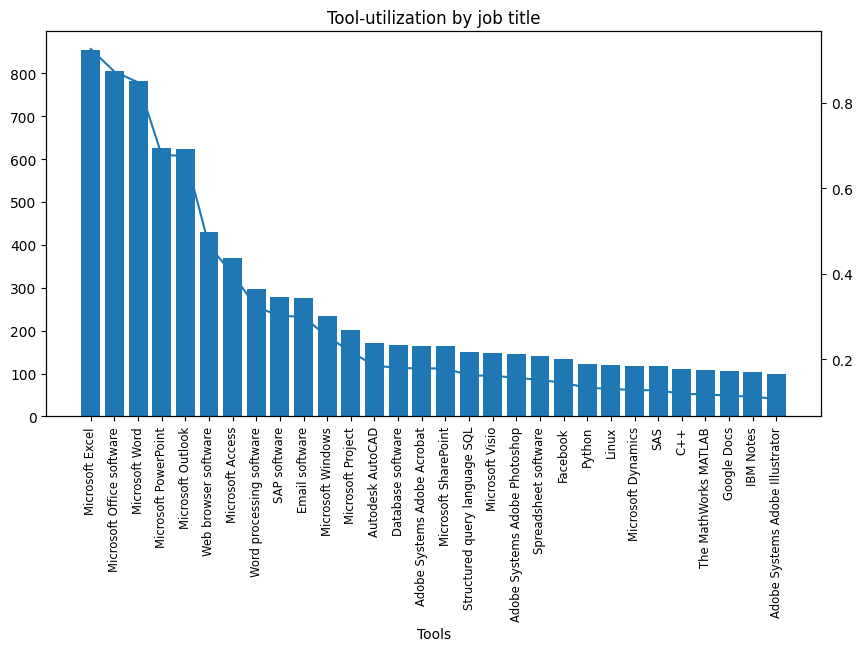

In [490]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.bar(tools_in_use.reset_index()["Tool"].head(30), tools_in_use["count"].head(30))
ax2.plot(tools_in_use.reset_index()["Tool"].head(30), tools_in_use["pct"].head(30))

ax1.tick_params(axis='x', labelsize='small', rotation=90)

ax1.set_xlabel("Tools")
plt.title('Tool-utilization by job title')

plt.savefig('Tool Utilization.jpg');
#label rotation help from https://github.com/matplotlib/matplotlib/issues/7150

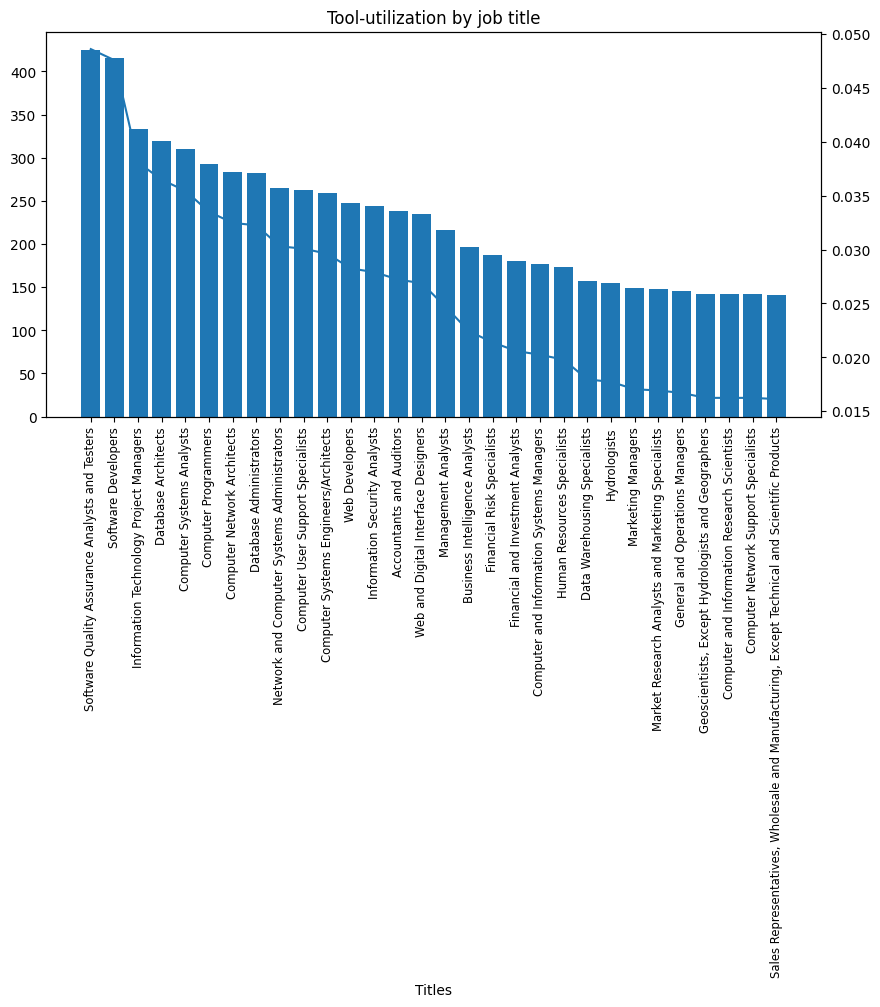

In [496]:
fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.bar(titles_using_tools.reset_index()["Title"].head(30), titles_using_tools["count"].head(30))
ax2.plot(titles_using_tools.reset_index()["Title"].head(30), titles_using_tools["pct"].head(30))

ax1.tick_params(axis='x', labelsize='small', rotation=90)

ax1.set_xlabel("Titles")
plt.title('Tool-utilization by job title')

plt.savefig('Tool Utilization by title.jpg');

Let's look at what jobs are most similar based on tool utilization. We will ll remove tools used by 60% or more of titles, as these will not be differentiating factors for clustering.

In [497]:
tools_to_include = tools_in_use.loc[tools_in_use['pct']< 0.60]

In [498]:
column_list_tools = tools_to_include.index.tolist()

In [499]:
tools_crosstab_filtered = tools_crosstab[column_list_tools]
#filter out tools which are used by 85% or more of occupations

In [500]:
#figuring out the optimal number of clusters
score = []

for k in range(10, 20):
    cl = KMeans(n_clusters=k, random_state=42, n_init=10)
    cl.fit(tools_crosstab_filtered)

    sil = silhouette_score(tools_crosstab_filtered, cl.labels_)


    score.append([k, cl.inertia_, sil])

score_df = pd.DataFrame(score, columns=['k', 'inertia', 'silhouette'])
score_df

,k,inertia,silhouette
0,10,21185.844660,0.110683
1,11,21164.331911,0.108902
2,12,20846.226601,0.131963
3,13,20563.445605,0.009676
4,14,20745.367116,0.119416
5,15,20182.381155,0.115676
6,16,20225.393734,0.008810
7,17,20227.290677,-0.003825
8,18,20311.963616,0.154418
9,19,19936.127681,0.122291


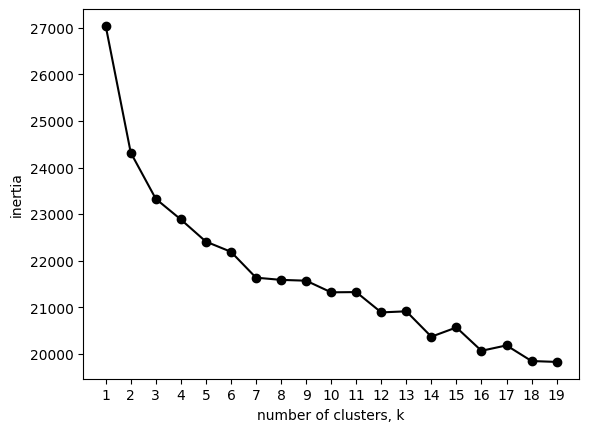

<Figure size 640x480 with 0 Axes>

In [155]:
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(tools_crosstab_filtered)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('Km_tools.jpg');

In [501]:
km_tools = KMeans(random_state=42, n_init=10, n_clusters=15)
km_tools.fit(tools_crosstab_filtered)
#not using standard scaler here, because the data is binary (1, yes tool is used; 0, no it's not used)

KMeans(n_clusters=15, n_init=10, random_state=42)

In [502]:
centroids = pd.DataFrame(
km_tools.cluster_centers_, columns = tools_crosstab_filtered.columns)

In [503]:
joblib.dump(km_tools, 'Km_tools.pkl')

['Km_tools.pkl']

It looks like the our jobs can be differentiated by tool use, using 15 clusters. This differentiation achieves the highest silhouette score.

In [141]:
km_tools = joblib.load('Km_tools.pkl')

In [504]:
tools_crosstab_filtered["cluster"] = km_tools.labels_
#adding the cluster label to the tools table

<ipython-input-504-3e61129c3854>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tools_crosstab_filtered["cluster"] = km_tools.labels_


We will also store the tool matrix with titles, so we can match titles by tool use in our app.

In [506]:
joblib.dump(tools_crosstab_filtered, 'tools.pkl')

['tools.pkl']

In [507]:
pca_2 = PCA(2)
pca_2_result = pd.DataFrame(pca_2.fit_transform(tools_crosstab_filtered),columns=['PC1','PC2'])

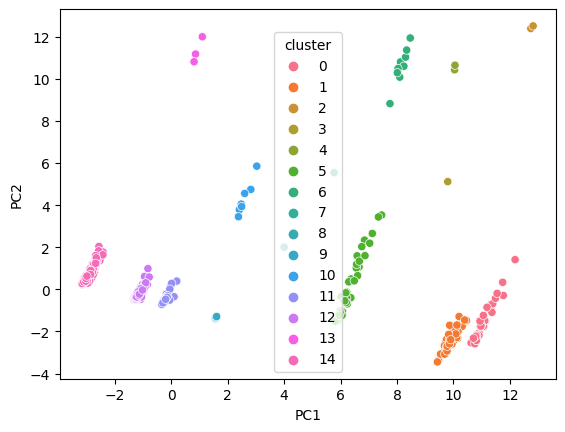

In [510]:
pca_2_result['cluster'] = pd.Categorical(km_tools.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_result)
plt.savefig('tool clusters.jpg');

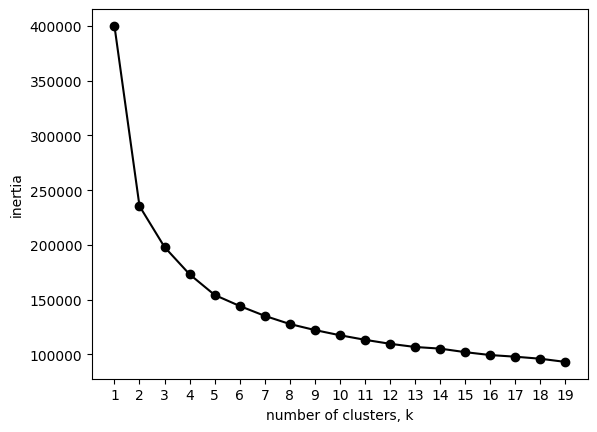

<Figure size 640x480 with 0 Axes>

In [656]:
#Let's see clustering by skill
ks = range(1, 20)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, n_init=10)

    # Fit model to samples
    model.fit(skills_)

    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()
plt.savefig('Km_skills.jpg');

In [657]:
km_skills = KMeans(random_state=42, n_init=10, n_clusters=7)
km_skills.fit(skills_)

KMeans(n_clusters=7, n_init=10, random_state=42)

In [658]:
centroids_skills = pd.DataFrame(
km_skills.cluster_centers_, columns = skills_.columns)

In [659]:
joblib.dump(km_skills, 'Km_skills.pkl')

['Km_skills.pkl']

In [662]:
skills_["cluster"] = km_skills.labels_

In [663]:
joblib.dump(skills_, 'skills.pkl')

['skills.pkl']

In [664]:
pca_2_skills = PCA(2)
pca_2_skills_result = pd.DataFrame(pca_2_skills.fit_transform(skills_),columns=['PC1','PC2'])

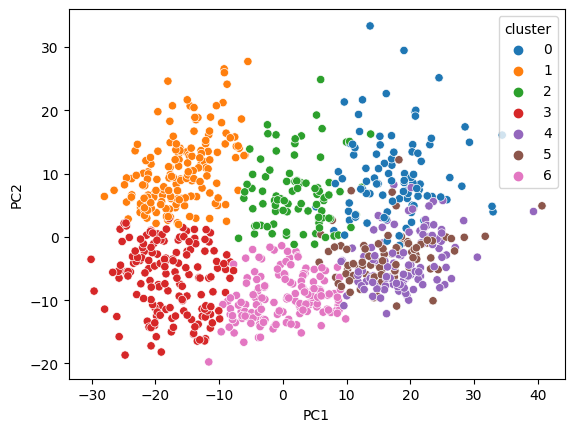

In [665]:
pca_2_skills_result['cluster'] = pd.Categorical(km_skills.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_2_skills_result)
plt.savefig('skill clusters.jpg');

Now, we'll see if tools help us predict AI Risk.

In [515]:
tech_merge = pd.merge(left = full_dataset_combined_[["Title", 'rank_new']], right = tools_crosstab_filtered,
                             left_on = "Title", right_on = "Title", how="left")

In [518]:
X_tools = tech_merge.drop(columns=["cluster", "rank_new"])

In [519]:
y_tools = tech_merge["rank_new"]

Lets combine this with Tasks NLP

In [25]:
df_lemm_task_ = pd.merge(left=df_lemm_task, right = full_dataset_combined_analysis["Title"], left_index=True, right_index = True, how="left")

In [42]:
combined_dataset = pd.merge(left=df_lemm_task_,right = tools_lemmed_, left_on = "Title", right_on="Title",how = "left")

## Abilities and Skills

Let's merge in the Abilities and Skills table (and keep only the interaction columns; level * importance)

In [43]:
abilities_skills = pd.read_pickle(r'./abilities_skills.pkl')

In [44]:
abilities_skills_filtered = abilities_skills.drop(abilities_skills.filter(regex ="_").columns, axis=1)
#keep only the interaction columns (where level * importance)

In [45]:
combined_dataset_ = pd.merge(left = combined_dataset, right = abilities_skills_filtered,
                             left_on = "Title", right_on = "Title", how="left")

In [48]:
industries["Industries_adjusted"] = industries["Industries"].str.replace(r'(\(.*?\))',"", regex=True)

In [49]:
industries["Industries_adjusted"]

0       Professional, Scientific, and Technical Services 
1       Information , Professional, Scientific, and Te...
2       Finance and Insurance , Professional, Scientif...
3                      Health Care and Social Assistance 
4                                          Manufacturing 
                              ...                        
999                                        Manufacturing 
1000                   Government , Educational Services 
1001    Professional, Scientific, and Technical Servic...
1002    Professional, Scientific, and Technical Servic...
1003    Government , Professional, Scientific, and Tec...
Name: Industries_adjusted, Length: 1004, dtype: object

In [50]:
industries.rename(columns = {"Occupation":"Title"}, inplace=True)

In [51]:
combined_dataset_full = pd.merge(left = combined_dataset_, right = industries[["Industries_adjusted","Title"]],
                             left_on = "Title", right_on = "Title", how="left")

In [52]:
combined_dataset_full["Industries_adjusted"] = combined_dataset_full["Industries_adjusted"].fillna("")

In [53]:
combined_dataset_full["combinedtext"] = combined_dataset_full[["Task","Title", "Tool","Industries_adjusted"]].apply('|'.join, axis=1)

In [54]:
features_to_drop_full = ['Task', 'Title', 'Tool','Industries_adjusted', 'rank_new']

In [55]:
Xfull = combined_dataset_full.drop(columns=features_to_drop_full)
yfull = combined_dataset_full["rank_new"]

In [56]:
Xfull.to_pickle("./Xfull.pkl")
yfull.to_pickle("./yfull.pkl")

In [468]:
Xfull = pd.read_pickle(r'Xfull.pkl')
yfull = pd.read_pickle(r'yfull.pkl')

In [469]:
Xfull_train, Xfull_test, y_train, y_test = train_test_split(Xfull,
                                                    yfull,
                                                    random_state=42, stratify=yfull)

In [470]:
column_trans = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [67]:
pipe_full_logr = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [198]:
pipe_full_logr.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a4ab6054580>),
                                                 ('combined', CountVectorizer(),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('logr', LogisticRegression(solver='liblinear'))])

In [199]:
pipe_full_logr_preds = pipe_full_logr.predict(Xfull_test)

In [200]:
logistic_full = evaluation("Logistical Regression - Full", y_test, pipe_full_logr_preds, pipe_full_logr,
                                Xfull_train, Xfull_test)

In [201]:
logistic_full

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,1.0,0.579,0.985,0.0,0.971,0.978


Significantly overfitting here. We need regularization and some solve for imbalanced data

In [215]:
pipe_params_cvec_full = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.01, 1.0, 10, 100],
    'logr__penalty': ['l2'],
    'logr__max_iter': [1000]
}

In [216]:
gs_full_cvec_logr = GridSearchCV(pipe_full_logr,
                pipe_params_cvec_full,
                  cv = 5)

In [217]:
gs_full_cvec_logr.fit(Xfull_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('scaled',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7a4ab6054580>),
                                                                        ('combined',
                                                                         CountVectorizer(),
                                                                         'combinedtext')],
                                                          verbose_feature_names_out=False)),
                                       ('logr',
                                        LogisticRegression(solver='liblinear'))]),
             param_grid={'logr__C...
                         'preprocess__combined__min_df': [2, 5],
                         'preprocess__combined__ngram_range': [(1, 1), (1, 2),
                                                               (2, 2)],
                         'preprocess__combined__stop_words': [['i', 'me', 'my',
                                                               'myself', 'we',
                                                               'our', 'ours',
                                                               'ourselves',
                                                               'you', "you're",
                                                               "you've",
                                                               "you'll",
                                                               "you'd", 'your',
                                                               'yours',
                                                               'yourself',
                                                               'yourselves',
                                                               'he', 'him',
                                                               'his', 'himself',
                                                               'she', "she's",
                                                               'her', 'hers',
                                                               'herself', 'it',
                                                               "it's", 'its',
                                                               'itself', ...]]})

In [218]:
gs_full_cvec_logr_preds = gs_full_cvec_logr.predict(Xfull_test)

In [219]:
logistic_full_regularized = evaluation("Logistical Regression - Full", y_test, gs_full_cvec_logr_preds, gs_full_cvec_logr,
                                Xfull_train, Xfull_test)

In [220]:
logistic_full_regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.954,0.6,1.0,0.0,0.974,0.987


Still overfitting - there's more to try:
1. lowercase/minor text processing on the combined data
2. additional regularization tweaking
3. different model
4. removing features
5. Onehotencode industries (instead of text analysis)

In [68]:
pipe_params_cvec_full_ = {
    'preprocess__combined__max_features' : [5000],
    'preprocess__combined__min_df' : [2,5],
    'preprocess__combined__max_df' : [0.9, 0.95],
    'preprocess__combined__ngram_range' : [(1,1), (1, 2), (2,2)],
    'preprocess__combined__stop_words' : [stops],
    'logr__C':[0.001, 0.1, 1.0, 10],
    'logr__penalty': ['l2','l1'],
    'logr__max_iter': [3000]
}

In [69]:
pipe_full_logr_ = Pipeline(
    steps = [
    ('preprocess', column_trans),
    ('logr', LogisticRegression(solver="liblinear"))
])

In [70]:
gs_full_cvec_logr_ = GridSearchCV(pipe_full_logr_,
                pipe_params_cvec_full_,
                  cv = 5)

In [ ]:
gs_full_cvec_logr_.fit(Xfull_train, y_train)

In [103]:
gs_full__cvec_logr_preds = gs_full_cvec_logr_.predict(Xfull_test)

In [104]:
logistic_full__regularized = evaluation("Logistical Regression - Full", y_test, gs_full__cvec_logr_preds, gs_full_cvec_logr_,
                                Xfull_train, Xfull_test)

In [105]:
logistic_full__regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.707,0.621,1.0,0.0,0.977,0.988


In [471]:
best_column_trans = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(max_features= 5000, min_df = 2, max_df = 0.95, ngram_range = (2,2), stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [472]:
best_pipe_full_logr = Pipeline(
    steps = [
    ('preprocess', best_column_trans),
    ('logr', LogisticRegression(solver="liblinear", C = 0.001, max_iter=3000, penalty = "l2", random_state=16))
])

In [473]:
best_pipe_full_logr.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f1db747bca0>),
                                                 ('combined',
                                                  CountVectorizer(max_df=0.95,
                                                                  max_features=5000,
                                                                  min_df=2,
                                                                  ngram_range=(2,
                                                                               2),
                                                                  stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('logr',
                 LogisticRegression(C=0.001, max_iter=3000, random_state=16,
                                    solver='liblinear'))])

In [474]:
best_pipe_full_logr_preds = best_pipe_full_logr.predict(Xfull_test)

In [475]:
joblib.dump(best_pipe_full_logr, 'Model.pkl')

['Model.pkl']

Removing Abilities and Industries

In [582]:
skills_ = pd.read_pickle(r'skills.pkl')

In [476]:
#removed abilities and industry from the analysis
combined_dataset_abridged = pd.merge(left = combined_dataset, right = skills_,
                             left_on = "Title", right_on = "Title", how="left")

In [543]:
skills_mean =skills_.describe().loc[['mean']]

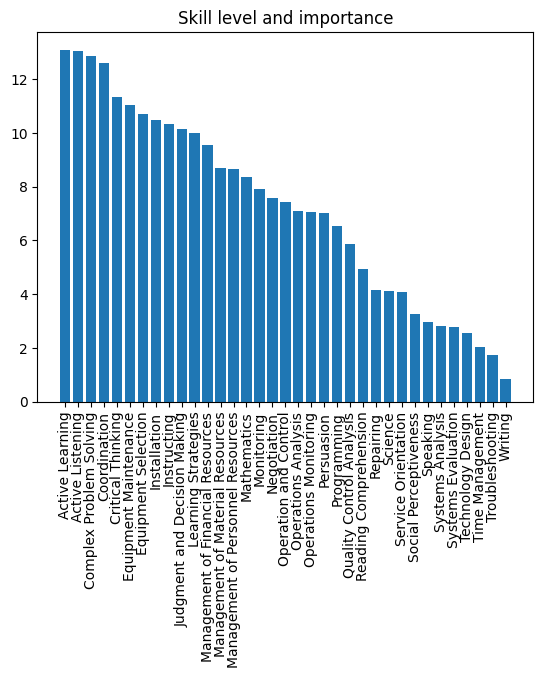

In [549]:
plt.bar(skills_mean.columns, skills_mean.loc["mean"].sort_values(ascending=False))
plt.xticks(fontsize=10, rotation = 90)
plt.title("Skill level and importance")
plt.savefig("Skills.jpg");


In [571]:
skills_.head(2)

Element Name,Active Learning,Active Listening,Complex Problem Solving,Coordination,Critical Thinking,Equipment Maintenance,Equipment Selection,Installation,Instructing,Judgment and Decision Making,...,Science,Service Orientation,Social Perceptiveness,Speaking,Systems Analysis,Systems Evaluation,Technology Design,Time Management,Troubleshooting,Writing
Title,,,,,,,,,,,,,,,,,,,,,
Accountants and Auditors,11.55,15.60,12.24,9.92,15.21,0.0,0.0,0.0,9.28,13.3,...,3.04,9.30,9.61,14.82,11.52,9.86,1.62,10.88,0.22,13.68
Actors,6.76,13.68,7.54,8.70,9.00,0.0,0.0,0.0,7.28,8.7,...,0.75,4.62,14.44,15.60,3.20,3.20,0.48,9.00,0.00,9.86


In [583]:
counts = [len(skills_.T[skills_.T[x]!=0.00]) for x in skills_.T]


In [617]:
skills_t = skills_.T

In [625]:
skills_index = skills_.T.reset_index()

In [591]:
skills_count = skills_t.append(pd.Series(counts, index = skills_t.columns),
           ignore_index=True)

<ipython-input-591-23fe7f3e3f79>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  skills_count = skills_.T.append(pd.Series(counts, index = skills_.T.columns),


In [628]:
skills_count_ = pd.merge(left = skills_count, right = skills_index["Element Name"], left_index = True, right_index= True, how = "left" )

In [637]:
skills_count_["Element Name"].fillna("count", inplace=True)

In [653]:
skills_count_sorted = skills_count_.set_index("Element Name").T.sort_values(by="count", ascending=False).tail(30)

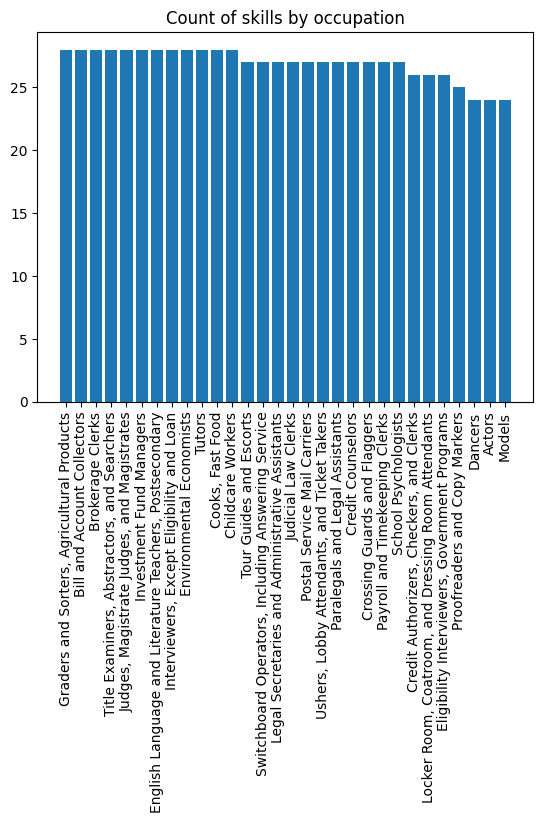

In [655]:
plt.bar(skills_count_sorted.index, skills_count_sorted["count"])
plt.xticks(fontsize=10, rotation = 90)
plt.title("Count of skills by occupation")
plt.savefig("Skill count.jpg");

### Multinomial

In [239]:
column_trans_mnb = ColumnTransformer(
  [('scaled', MinMaxScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [242]:
pipe_full_mnb = Pipeline(
    steps = [
    ('preprocess', column_trans_mnb),
    ('mnb', MultinomialNB(alpha=0.01))
])

In [243]:
pipe_full_mnb.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7a4ab593b9d0>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('mnb', MultinomialNB(alpha=0.01))])

In [264]:
gs_full_cvec_mnb_preds = pipe_full_mnb.predict(Xfull_test)

In [265]:
multinomial_full_regularized = evaluation("Logistical Regression - Full", y_test, gs_full_cvec_mnb_preds, pipe_full_mnb,
                                Xfull_train, Xfull_test)

In [266]:
multinomial_full_regularized

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression - Full,0.972,0.6,0.986,0.0,0.973,0.979


Try gridsearch on multinomial
Try removing some variables

Also clear that the sample size just isn't big enough and the high impact occupations are underpresented in the dataset.

Consider flipping the data analysis and mapping to the AI Index dataset (which has more occupation rows)

### KNN

In [94]:
from sklearn.neighbors import KNeighborsClassifier

In [96]:
column_trans_knn = ColumnTransformer(
  [('scaled', StandardScaler(),make_column_selector(dtype_include=np.number)),
  ('combined', CountVectorizer(stop_words = stops), 'combinedtext')],
  remainder='drop', verbose_feature_names_out=False
  )

In [97]:
pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier())
])

In [98]:
pipe_full_knn.fit(Xfull_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('scaled', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ca83f4c72b0>),
                                                 ('combined',
                                                  CountVectorizer(stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                                              'its',
                                                                              'itself', ...]),
                                                  'combinedtext')],
                                   verbose_feature_names_out=False)),
                ('knn', KNeighborsClassifier())])

In [99]:
pipe_full_knn.score(Xfull_test, y_test)

0.5789473684210527

In [100]:
scores = []

for k in range(3, 32, 2):
    pipe_full_knn = Pipeline(
    steps = [
    ('preprocess', column_trans_knn),
    ('knn', KNeighborsClassifier(n_neighbors=k))
])
    pipe_full_knn.fit(Xfull_train, y_train)
    acc_train = pipe_full_knn.score(Xfull_train, y_train)
    acc_test = pipe_full_knn.score(Xfull_test, y_test)
    scores.append((k, acc_train, acc_test))

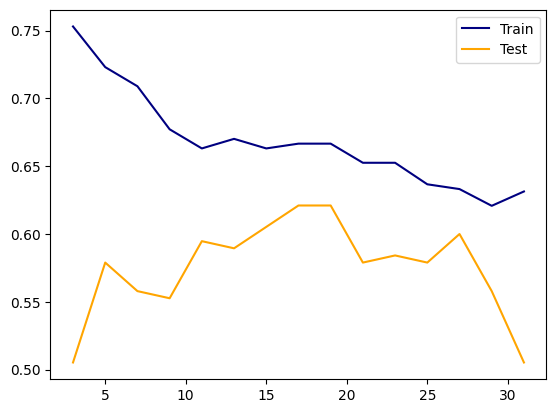

In [103]:
df_score = pd.DataFrame(scores, columns=['k', 'acc_train', 'acc_test'])
plt.plot(df_score.k, df_score.acc_train, c='navy', label='Train')
plt.plot(df_score.k, df_score.acc_test, c='orange', label='Test')
plt.legend();
plt.savefig('Knn.jpg')

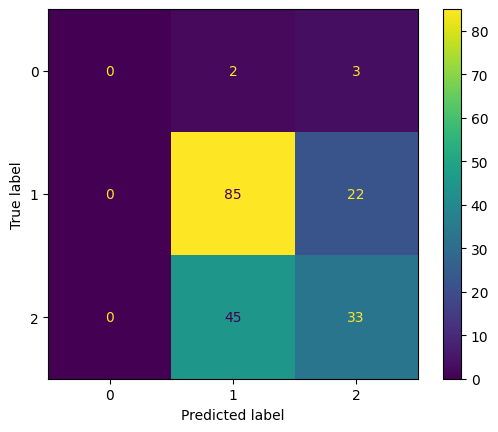

In [274]:
cm = confusion_matrix(y_test,gs_full__cvec_logr_preds )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [294]:
test = gs_full_cvec_logr_.predict_proba(Xfull_test)

Trying just simple abilities, skills land industry (OHE)

### Industry analysis

In [328]:
industries_copy = industries.copy()

In [329]:
exp_cols = industries["Industries"].str.split(r'(\(.*?\))', expand=True)
industries = pd.merge(industries, exp_cols, left_index=True, right_index=True, how="left")

In [330]:
industries.columns = ["Code",
                      "Title",	"Projected Growth (2022-2032)",
                      "Projected Job Openings (2022-2032)",
                      "Industries",
                      "Industries_adjusted",
                      "Split_0", "Split_1",
                      "Split_2",	"Split_3",	"Split_4",	"Split_5",
                      "Split_6",	"Split_7",	"Split_8",	"Split_9",	"Split_10",
                      "Split_11","Split_12","Split_13"]

In [331]:
industries["Split_0"].replace(r'(\(.*?\)), ',"", regex=True, inplace=True)
industries.replace(r'(\(.*?\))',"", regex=True, inplace=True)

In [332]:
enci = OneHotEncoder(sparse_output=False)

In [333]:
ohedata = pd.DataFrame(enci.fit_transform(industries[["Industries_adjusted"]]), columns=enci.categories_).reset_index()

In [334]:
industries = pd.merge(left=industries, right=ohedata, left_index=True, right_index=True, how="left")

In [335]:
industries.columns = ['Code',
                                                      'Title',
                               'Projected Growth (2022-2032)',
                         'Projected Job Openings (2022-2032)',
                                                 'Industries',
                                        'Industries_adjusted',
                                                    'Split_0',
                                                    'Split_1',
                                                    'Split_2',
                                                    'Split_3',
                                                    'Split_4',
                                                    'Split_5',
                                                    'Split_6',
                                                    'Split_7',
                                                    'Split_8',
                                                    'Split_9',
                                                   'Split_10',
                                                   'Split_11',
                                                   'Split_12',
                                                   'Split_13',
                                                      'index',
                            'Accommodation and Food Services',
                        'Administrative and Support Services',
                'Agriculture, Forestry, Fishing, and Hunting',
                        'Arts, Entertainment, and Recreation',
                                               'Construction',
                                       'Educational Services',
                                      'Finance and Insurance',
                                                 'Government',
                          'Health Care and Social Assistance',
                                               'Information ',
                    'Management of Companies and Enterprises',
                                              'Manufacturing',
              'Mining, Quarrying, and Oil and Gas Extraction',
                                             'Other Services',
           'Professional, Scientific, and Technical Services',
                         'Real Estate and Rental and Leasing',
                                               'Retail Trade',
                             'Transportation and Warehousing',
                                                  'Utilities',
                                            'Wholesale Trade']

In [336]:
industry_analysis = pd.merge(left=full_dataset_combined_[["O*NET-SOC Code", "rank_new"]], right=industries, left_on="O*NET-SOC Code", right_on="Code", how="left")

In [337]:
X_industry = industry_analysis[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']]

In [338]:
y_industry = industry_analysis["rank_new"]

In [339]:
X_industry.fillna(0, inplace=True)

<ipython-input-339-77c32d80a8bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_industry.fillna(0, inplace=True)


In [340]:
Xind_train, Xind_test, y_train, y_test = train_test_split(X_industry,
                                                    y_industry,
                                                    random_state=42, stratify=y_industry)

In [341]:
logr_industry = LogisticRegression()

In [342]:
logr_industry.fit(Xind_train, y_train)

LogisticRegression()

In [343]:
logr_industry.score(Xind_test,  y_test)

0.5842105263157895

We can see that industry alone has a very small relationship with ai risk for a particular job title. However, we only looked at the dominant industry for an occupation. What if we look at all industries associated with an occupation?

In [344]:
s=pd.DataFrame([[x] + [z] for x, y in zip(industries_copy.index,industries_copy.Industries.str.split(r'(\(.*?\))')) for z in y],
               columns=[0,'Industry'])
industries_split =s.merge(industries_copy,left_on=0,right_index=True).drop(0,1)
#https://stackoverflow.com/questions/55981347/how-to-split-and-duplicate-rows-according-to-string-in-one-column-with-python

<ipython-input-344-bf76528bf09e>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  industries_split =s.merge(industries_copy,left_on=0,right_index=True).drop(0,1)


In [345]:
industries_split.sort_values(by="Industry")

,Industry,Code,Occupation,Projected Growth (2022-2032),Projected Job Openings (2022-2032),Industries
4973,,19-1023.00,Zoologists and Wildlife Biologists,Average,1500,"Government (65%), Professional, Scientific, an..."
2211,,39-3019.00,"Gambling Service Workers, All Other",Little or no change,2100,"Arts, Entertainment, and Recreation (39%), Gov..."
742,,27-2022.00,Coaches and Scouts,Much faster than average,38400,"Educational Services (64%), Arts, Entertainmen..."
2200,,11-9071.00,Gambling Managers,Average,600,"Government (35%), Accommodation and Food Servi..."
2193,,39-3011.00,Gambling Dealers,Little or no change,12100,"Accommodation and Food Services (40%), Arts, E..."
...,...,...,...,...,...,...
4258,Wholesale Trade,11-2022.00,Sales Managers,Average,43200,"Wholesale Trade (20%), Retail Trade (18%), Pro..."
1789,Wholesale Trade,49-3041.00,Farm Equipment Mechanics and Service Technicians,Faster than average,4300,"Wholesale Trade (57%), Agriculture, Forestry, ..."
4290,Wholesale Trade,41-4011.07,Solar Sales Representatives and Assessors,Average,28500,"Wholesale Trade (54%), Manufacturing (12%), In..."
3512,Wholesale Trade,43-4151.00,Order Clerks,Decline,11200,"Wholesale Trade (23%), Retail Trade (23%), Man..."


In [346]:
industries_split["Industry"].replace(r'(\(.*?\))',"", regex=True, inplace=True)

In [347]:
industries_split_filtered = industries_split[industries_split['Industry'] != ""]
#remove blank rows

In [348]:
def trimfunc(str):
    if str[:2] == ', ':
        return str.lstrip(', ')
    else:
        return str
#help from Sonyah to remove leading commas

In [349]:
industries_split_filtered['Industry']= industries_split_filtered['Industry'].apply(lambda x: trimfunc(x))

<ipython-input-349-f6595690f67b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industries_split_filtered['Industry']= industries_split_filtered['Industry'].apply(lambda x: trimfunc(x))


In [350]:
enci = OneHotEncoder(sparse_output=False)

In [351]:
ohedata_ = pd.DataFrame(enci.fit_transform(industries_split_filtered[["Industry"]]),
                       columns=enci.categories_).reset_index()

In [352]:
industries_ = pd.merge(left=industries_split_filtered, right=ohedata_, left_index=True, right_index=True, how="left")

In [353]:
industries_analysis = pd.merge(left=industries_,
                             right=full_dataset_combined_[["O*NET-SOC Code", "rank_new"]], left_on="Code", right_on="O*NET-SOC Code", how="left")

In [357]:
industries_analysis.columns= ['Industry','Code','Occupation',
                              'Projected Growth (2022-2032)',
                        'Projected Job Openings (2022-2032)',
                                                'Industries',
                                                      'index',
                              "",
                            'Accommodation and Food Services',
                        'Administrative and Support Services',
                'Agriculture, Forestry, Fishing, and Hunting',
                        'Arts, Entertainment, and Recreation',
                                               'Construction',
                                       'Educational Services',
                                      'Finance and Insurance',
                                                 'Government',
                          'Health Care and Social Assistance',
                                               'Information ',
                    'Management of Companies and Enterprises',
                                              'Manufacturing',
              'Mining, Quarrying, and Oil and Gas Extraction',
                                             'Other Services',
           'Professional, Scientific, and Technical Services',
                         'Real Estate and Rental and Leasing',
                                               'Retail Trade',
                             'Transportation and Warehousing',
                                                  'Utilities',
                                            'Wholesale Trade',
                                            'O*NET-SOC Code',
                                                  'rank_new']

In [ ]:
industries_analysis.dropna(inplace=True)
#unmatched rank columns

In [ ]:
Xinds = industries_analysis[['Accommodation and Food Services',
        'Administrative and Support Services',
        'Agriculture, Forestry, Fishing, and Hunting',
        'Arts, Entertainment, and Recreation', 'Construction',
        'Educational Services', 'Finance and Insurance', 'Government',
        'Health Care and Social Assistance', 'Information ',
        'Management of Companies and Enterprises', 'Manufacturing',
        'Mining, Quarrying, and Oil and Gas Extraction',
        'Other Services',
        'Professional, Scientific, and Technical Services',
        'Real Estate and Rental and Leasing', 'Retail Trade',
        'Transportation and Warehousing', 'Utilities',
        'Wholesale Trade']]

In [ ]:
yinds = industries_analysis['rank_new']

In [ ]:
Xinds_train, Xinds_test, y_train, y_test = train_test_split(Xinds,
                                                    yinds,
                                                    random_state=42, stratify=yinds)

In [ ]:
logr_industries = LogisticRegression()

In [ ]:
logr_industries.fit(Xinds_train, y_train)

In [ ]:
logr_industries.score(Xinds_test,  y_test)

This model does worse than the original single-industry analysis, indicating that industries aren't indicative of AI risk for an occupation. Something else must be driving the AI risk determination.

We will remove industry from the full analysis.

### Tool utilization by occupation

We'll move forward with creating a table, where tools are grouped by occupation, to see how 'tool combinations' are related to AI Risk.
This is intended to showcase how a composite of tools in a single occupation can make an occupation more or less susceptible to AI replacement.

In [358]:
tech_df =techskills.groupby("O*NET-SOC Code")["Tool"].apply(np.unique)

In [359]:
tech_df.reset_index()

,O*NET-SOC Code,Tool
0,11-1011.00,"[AdSense Tracker, Adobe Systems Adobe Acrobat,..."
1,11-1011.03,"[Adobe Systems Adobe Acrobat, Adobe Systems Ad..."
2,11-1021.00,"[ADP Workforce Now, AMG Teleran SalesInSync, A..."
3,11-1031.00,"[Adobe Systems Adobe Acrobat, Adobe Systems Ad..."
4,11-2011.00,"[Actuate BIRT, AdRelevance, Adobe Systems Adob..."
...,...,...
918,53-7071.00,[Computerized maintenance management system CM...
919,53-7072.00,[Computerized maintenance management system CM...
920,53-7073.00,"[Microsoft Excel, Microsoft Office software, M..."
921,53-7081.00,"[AMCS Platform, Computerized maintenance manag..."


In [360]:
tech_df_ = pd.merge(left = tech_df, right =full_dataset_combined_,
                             left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [361]:
tech_df_filtered = tech_df_[tech_df_['rank_new'].notna()]

In [362]:
df_lemm_tool = tech_df_filtered["Tool"].apply(', '.join)

In [363]:
tools_lemmed_ = pd.merge(left=df_lemm_tool, right=tech_df_filtered[["Title","rank_new"]],
                         left_index=True, right_index=True, how="left")

In [364]:
tools_count = pd.merge(left = techskills, right = tech_df_filtered,
                       left_on = "O*NET-SOC Code", right_on = "O*NET-SOC Code", how="left")

In [368]:
#Low AI Risk
tools_count_low = tools_count[tools_count["rank_new"]==1.0]
tools_count_low_ = tools_count_low.groupby("Tool_x").agg(["count"]).reset_index()
tools_count_low_.columns = ["Tool_x", "count"]
tools_count_low_["pct"] = tools_count_low_["count"]/len(tools_count_low_)
tools_count_low_["pct"] = tools_count_low_["pct"].apply('{:.00%}'.format)
tools_count_low_ = tools_count_low_.sort_values(by=["pct"], ascending=False)

ValueError: ignored

In [ ]:
tools_count_med = tools_count_[tools_count_["rank_new"]==2.0]
tools_count_med_ = tools_count_med.groupby("Tool_1").agg(["count"]).reset_index()
tools_count_med_.columns = ["Tool_1", "count"]
tools_count_med_["pct"] = tools_count_med_["count"]/len(tools_count_med_)
tools_count_med_["pct"] = tools_count_med_["pct"].apply('{:.00%}'.format)
tools_count_med_ = tools_count_med_.sort_values(by=["pct"], ascending=False)

In [ ]:
tools_count_high = tools_count_[tools_count_["rank_new"]==0.0]
tools_count_high_ = tools_count_high.groupby("Tool_1").agg(["count"]).reset_index()
tools_count_high_.columns = ["Tool_1", "count"]
tools_count_high_["pct"] = tools_count_high_["count"]/len(tools_count_high_)
tools_count_high_["pct"] = tools_count_high_["pct"].apply('{:.00%}'.format)
tools_count_high_ = tools_count_high_.sort_values(by=["pct"], ascending=False)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10), tight_layout=True, sharex=False, sharey=False)
plt.xticks(rotation=30, ha='right')

ax1 = sns.barplot(x=tools_count_low_["Tool_1"].head(30), y=tools_count_low_["count"],
            color='#78909c', ax=axes[0]).set(title='Tool Requirements - Low AI Risk Occupations')

ax2 = sns.barplot(x=tools_count_med_["Tool_1"].head(30), y=tools_count_med_["count"],
            color='#4dd0e1', ax=axes[1]).set(title='Tool Requirements - Medium AI Risk Occupations')


ax3 = sns.barplot(x=tools_count_high_["Tool_1"].head(30), y=tools_count_high_["count"],
            color='#0c71e0', ax=axes[2]).set(title='Tool Requirements - High AI Risk Occupations');



In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), tight_layout=True)

(tools_lemmed_v[tools_lemmed_v['rank_new'] == 0.0]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tools - High AI Impact', color='#78909c', fontsize=8, ax=axes[0])).invert_yaxis();


(tools_lemmed_v[tools_lemmed_v['rank_new'] == 2.0]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tools - Medium AI Impact', color='#4dd0e1', fontsize=8, ax=axes[1])).invert_yaxis();


(tools_lemmed_v[tools_lemmed_v['rank_new'] == 1.0]
    .drop(columns=['rank_new'])
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .plot(kind='barh', title='Top Trigrams for Tools - Low AI Impact', color='#0c71e0', fontsize=8, ax=axes[2])).invert_yaxis();


fig.suptitle('Tool Analysis - Trigrams', fontsize=16);

In [ ]:
Xtool = df_lemm_tool

In [ ]:
ytool = tech_df_filtered["rank_new"]

In [ ]:
Xtool_train, Xtool_test, y_train, y_test = train_test_split(Xtool,
                                                    ytool,
                                                    random_state=42, stratify=ytool)

In [ ]:
ytool.value_counts(normalize=True)

In [ ]:
y_tools.value_counts(normalize=True)

We need to have our model predict at least 56% of the target in order to be better than the baseline.
Model predicts that nearly 3% of jobs in the series (with a match to the AI threat data) is at risk.

In [ ]:
pipe_params_cvec = {
    'cvec__max_features' : [5000],
    'cvec__min_df' : [2,5],
    'cvec__max_df' : [0.9],
    'cvec__ngram_range' : [(1,1), (1, 2)],
    'cvec__stop_words' : [stops],
    }

In [ ]:
pipe_params_tvec = {
    'tvec__max_features' : [5000],
    'tvec__min_df' : [2,5],
    'tvec__max_df' : [0.9, 0.95],
    'tvec__ngram_range' : [(1,1), (1, 2), (2,2)],
    'tvec__stop_words' : [stops],
}

In [ ]:
pipe_cvec_logr_tool = Pipeline([
    ('cvec', CountVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [ ]:
gs_tool_cvec_logr = GridSearchCV(pipe_cvec_logr_tool,
                pipe_params_cvec,
                  cv = 5)

In [ ]:
gs_tool_cvec_logr.fit(Xtool_train, y_train)

In [ ]:
gs_tool_cvec_logr_preds = gs_tool_cvec_logr.predict(Xtool_test)

In [ ]:
logistic_cvec_tool = evaluation("Logistical Regression CVEC - Tool", y_test, gs_tool_cvec_logr_preds, gs_tool_cvec_logr,
                                Xtool_train, Xtool_test)

In [ ]:
logistic_cvec_tool

In [ ]:
pipe_tvec_logr_tool = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logr', LogisticRegressionCV(solver = 'liblinear'))
])

In [ ]:
gs_tool_tvec_logr = GridSearchCV(pipe_tvec_logr_tool,
                pipe_params_tvec,
                  cv = 5)

In [ ]:
gs_tool_tvec_logr.fit(Xtool_train, y_train)

In [ ]:
gs_tool_tvec_logr_preds = gs_tool_tvec_logr.predict(Xtool_test)

In [ ]:
logistic_tvec_tool = evaluation("Logistical Regression TVEC - Tool", y_test, gs_tool_tvec_logr_preds, gs_tool_tvec_logr,
                                Xtool_train, Xtool_test)

In [ ]:
logistic_tvec_tool

### Using Tools as Binary Indicators in the model

In [80]:
X_tool_train, X_tool_test, y_train, y_test = train_test_split(X_tools,
                                                    y_tools,
                                                    random_state=42, stratify=y_tools)
#Using binary tool data by title

In [74]:
logr_bi_tools = LogisticRegression(multi_class="multinomial")

In [85]:
pipe_params_logr_cvec_bi = {
    'C': [0.01, 1.0, 10, 100],
    'penalty': ['l2'],
    'max_iter': [1000]}
    #'mnb__alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],

In [86]:
gs_toolbi_cvec_logr = GridSearchCV(logr_bi_tools,
                                  pipe_params_logr_cvec_bi,
                                  cv=5)

In [87]:
gs_toolbi_cvec_logr.fit(X_tool_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.01, 1.0, 10, 100], 'max_iter': [1000],
                         'penalty': ['l2']})

In [88]:
gs_toolbi_cvec_logr_preds = gs_toolbi_cvec_logr.predict(X_tool_test)
#analyzing tool data as binary indicators

In [90]:
logistic_cvec_toolbi = evaluation("Logistical Regression CVEC - Tool (Binary)", y_test, gs_toolbi_cvec_logr_preds, gs_toolbi_cvec_logr,
                                X_tool_train, X_tool_test)

In [91]:
logistic_cvec_toolbi

,Model,Score on train,Score on test,Sensitivity,Specificity,Precision,F1 Score
0,Logistical Regression CVEC - Tool (Binary),0.697,0.568,1.0,0.0,0.97,0.985


## Clustering

In [ ]:
df_lemm_tool

0      AdSense Tracker|Adobe Systems Adobe Acrobat|At...
1      Adobe Systems Adobe Acrobat|Adobe Systems Adob...
2      ADP Workforce Now|AMG Teleran SalesInSync|Act!...
4      Actuate BIRT|AdRelevance|Adobe Systems Adobe A...
5      AEC Software FastTrack Schedule|AdSense Tracke...
                             ...                        
915    Machine operation software|Microsoft Excel|Mic...
916    Autodesk AutoCAD|Inventory tracking software|M...
917    Data entry software|Eko|Email software|Google ...
919    Computerized maintenance management system CMM...
922    CompuWeigh GMS|Distributed control system DCS|...
Name: Tool, Length: 757, dtype: object

## Streamlit mechanics

User enters tool, skill or ability
App spits out Top 5 jobs they could do
--> Need to scrub text so it's character free
--> Need to partial match text to Task column
--> Need to select top 5 titles that are in the cluster for this tool, skill or ability,italicized text and also include the AI risk for these jobs

User selects occupation
App tells them whether it's Low Medium or High AI Risk



enter Job Title
fuzzy match to existing title
map to AI Risk
map to cluster (abilities, skills, tools, tasks)
spit out jobs within cluster with the closest match and lowest AI index

In [369]:
def text_process(text):
  stops = nltk.corpus.stopwords.words('english')
  new_stop_words = ["whom"]
  stops.extend(new_stop_words)

  w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
  lemmatizer = WordNetLemmatizer()

  words = [x.lower() for x in text.split() if (x not in stops) and (len(x)>1)]
  sentence = " ".join(words)
  splits = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(sentence)]
  list_of_sentences = " ".join(splits)

  return list_of_sentences

In [386]:
text_jobs = input('Identify the job(s) you are interested in pursuing: ')

Identify the job(s) you are interested in pursuing: Sleeping


In [387]:
text_tasks = input('Identify the task(s) you are energized to perform as part of your job: ')

Identify the task(s) you are energized to perform as part of your job: sleeping


In [398]:
text_tools = input('Identify the tool(s) you have experience using: ')

Identify the tool(s) you have experience using: sleeping


In [399]:
text_job = text_process(text_jobs)
text_task = text_process(text_tasks)
text_tool = text_process(text_tools)

In [409]:
#dummy for test in python
text_skills = ['sleep']

In [ ]:
#option = st.selectbox(
#   'Identify the skill(s) you are excited to leverage:',
#    ([:-1:]))

#st.write('You selected:', option)
#for streamlit

In [374]:
Xfull = pd.read_pickle("./Xfull.pkl")

In [463]:
skills = pd.read_pickle("skills.pkl")

In [410]:
Xstreamlit = pd.DataFrame(columns = Xfull.columns, index=[0])
Xstreamlit.fillna(0, inplace=True)

In [411]:
for i in range(len(text_skills)):
  if text_skills[i] in Xstreamlit.columns:
    Xstreamlit.loc[0][text_skills[i]] = 1

In [404]:
combinedtext_ = [text_process(text_tasks),text_process(text_job), text_process(text_tools)]
combinedtext = "|".join([str(item) for item in combinedtext_])

In [413]:
Xstreamlit["combinedtext"] = combinedtext

In [382]:
model = joblib.load("Model.pkl")

In [414]:
prediction = model.predict(Xstreamlit)[0]

In [415]:
proba = model.predict_proba(Xstreamlit)[0]
proba

array([0.34145656, 0.14211945, 0.51642399])

In [394]:
if prediction == 0:
  probability = model.predict_proba(Xstreamlit)[0][0]
elif prediction == 1:
  probability = model.predict_proba(Xstreamlit)[0][1]
else:
  probability = model.predict_proba(Xstreamlit)[0][2]

In [395]:
if prediction == 0:
  print(f"AI poses a HIGH risk to your selected job.")
elif prediction > 0.5:
  print(f"AI poses a MODERATE risk to your selected job.")
else:
  print(f"AI poses a LOW risk to your selected job.")

AI poses a MODERATE risk to your selected job.


In [419]:
#clusters
km_tools = joblib.load("Km_tools.pkl")

In [420]:
#Tools
tools = joblib.load("tools.pkl")

In [426]:
Xstreamlit_tools = pd.DataFrame(columns = tools.columns, index=["input", "match", "fuzzy_match"])
Xstreamlit_tools.fillna(0, inplace=True)

In [427]:
tools_list = list(text_tools.split(", "))

In [428]:
for i in range(len(tools_list)):
    j = tools_list[i]
    if len(difflib.get_close_matches(j,Xstreamlit_tools.columns)) != 0:
        k = difflib.get_close_matches(j,Xstreamlit_tools.columns, cutoff=0.8)
        Xstreamlit_tools.loc["input",k] = 1
        Xstreamlit_tools.loc["match",k] = tools_list[i]
        Xstreamlit_tools.loc["fuzzy_match",k] = k[0]

In [448]:
cluster = km_tools.predict(Xstreamlit_tools.head(1))[0]

In [451]:
tools["cluster"]= km_tools.labels_

In [462]:
top_tools_jobs = pd.DataFrame(tools[tools["cluster"]==cluster].head(3).index)
top_tools_jobs

,Title
0,Actors
1,Acupuncturists
2,Acute Care Nurses
